
# Original Glicko

The original Glicko system was created by Mark Glickman in 1995. You can read about it in detail on Mark Glickman's website http://glicko.net/. It was one of the first, if not *the* first attempt at incorporating uncertainty into a Elo-style ratings system. It often outperforms basic Elo for that reason, while keeping Elo's advantages. There are still very few parameters to tune, and it is still fairly universal, and it is computationally quick. While Glicko is generally outperformed by some more computationally intensive and new methods, it serves as a great baseline while rating player or team performance. 

Glicko 2 was developed later, and has an additional parameter. However, I haven't found much difference between the two.

### Advantages

- Quicker to converge than Elo
- Better at updating once converged than Elo
- Simplicity
- Computational speed
- Universality
- Ratings 'memory' - correct league heirarchies develop with enough data
- Not much tuning needed - the default RD of 350 usually gives you reasonable results, rarely is a much different value needed

### Disadvantages

- Cannot account for score difference. A win by 50 is the same as a win by 5.
- Slower to converge than TrueSkill
- There is no attempt to model style of play or player idiosyncracies
- Without some edits, it will not put more weight on certain games than others, i.e., if a team or player is particularly motivated, or if the total time in a match varies. 
- As with any rating system, if players are allowed to selectively choose opponents, it can ruin the fidelity of the ratings
- Is meant for 1v1 ratings, or team v team. Cannot innately handle 1vMany or Many vs. Many.



In [145]:

import gc
import os

import numpy as np
import pandas as pd

from copy import copy
from tqdm import tqdm
from oddsmaker.state_space import Glicko
from pandas.api.types import is_datetime64_any_dtype as is_datetime



## Quick Start

Here, I'll show how you can use the oddsmaker Glicko class to model team ratings, and compare it to Elo. The class takes data in a specific format. Once you learn that format, it becomes powerful.


In [146]:


class Glicko():

    """
    
    Glicko rating system implementation

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing the following columns:
            - protag_id: protagonist id (player or team)
            - antag_id: antagonist id (player or team)
            - stat: Specifies stat involved
            - result: 0 for loss, 1 for win, 0.5 for tie
            - is_home (optional): 1 for home, -1 for away, 0 for neutral
            - date or rating period: date of game or rating period of game
    protag_id : str, optional
        Name of protagonist id column, by default 'team_name'
    antag_id : str, optional    
        Name of antagonist id column, by default 'opp_name' 
    result_col : str, optional
        Name of result column, by default 'result'
    RD : int, optional
        Initial RD (sigma, or standard deviation) value, by default 350
    max_RD : int, optional    
        Maximum RD value, by default 350. Usually same as initial RD
    time_param : float, optional
        Time parameter, by default 1. Multiplies by time elapsed. The lower the value, the slower the rating variance goes back to default
    hfa : int, float, or dict, optional
        Home field advantage value(s) to use for each stat. Used to create 'hfa' column. If 'hfa' column already provided, then ignores. If int or float, applies to all stats. If dict, applies to each stat individually. If None, no home field advantage is used. Default is None.
    priors : dict, optional
        Dictionary of priors to use for each stat. If None, no priors are used. Default is None.


    """

    def __init__(
            self, 
            data, 
            protag_id='protag_id', 
            antag_id='antag_id', 
            result_col='result', 
            RD=350, 
            max_RD=350, 
            time_param=1, 
            matchup_type='1v1',
            hfa=None, 
            priors=None
        ):

        self.data = data.copy()
        self.protag_id = protag_id
        self.antag_id = antag_id
        self.result_col = result_col
        self.RD = RD
        self.max_RD = max_RD
        self.time_param = time_param
        self.hfa = hfa
        self.matchup_type = matchup_type
        self.col_names = list(self.data)
        self.col_names = [cn.lower().strip() for cn in self.col_names]
        self.data.columns=self.col_names
        
        ## constant
        self.q = np.log(10)/400

        ### validation checks
        assert(self.protag_id in list(data)), f"{self.protag_id} not in columns, please specify team column name with protag_id argument"
        assert(self.antag_id in list(data)), f"{self.antag_id} not in columns, please specify opponent column name with antag_id argument"

        assert('stat' in list(self.data)), 'No stat column, please add a stat name column to your data'
        self.stats = sorted(list(self.data.stat.unique()))
        self.result_col = result_col
        assert(self.result_col in list(self.data)), 'Please include an outcome/result column, can specify the name with result col argument'
        assert((('date' in self.col_names)|('rating_period' in self.col_names))), "Need either a date column or a rating period column"
        if 'date' in self.col_names:
            self.period_type = 'date'
            assert(is_datetime(self.data[self.period_type].dtype)), "Date column must be of type datetime"
        else:
            self.period_type = 'rating_period'

        assert(self.matchup_type in ['1v1','1vMany','ManyvMany','Multiple']), "matchup_type must be one of ['1v1','1vMany','ManyvMany','Multiple']"
        if self.matchup_type == 'Multiple':
            assert('matchup_type' in list(self.data)), "matchup_type is set to 'Multiple', but no matchup_type column found in data"
            for mtype in self.data.matchup_type.unique():
                assert(mtype in ['1v1','1vMany','ManyvMany']), "Unrecognized matchup_type, must be one of ['1v1','1vMany','ManyvMany']"
        else:   
            self.data['matchup_type'] = self.matchup_type

        self.num_protags = len(self.data[self.protag_id].unique())
        self.num_antags = len(self.data[self.antag_id].unique())
        self.num_stats = len(self.data.stat.unique())
        self.num_games = len(self.data)//2

        self.rating_matrix = np.ones((self.num_protags, self.num_stats, 3))*1500
        self.rating_matrix[:,:,1] = self.RD
        self.rating_matrix[:,:,2] = 120 # default time off. Not used initially, so just placeholder

        ### check if data is symmetrical, i.e., for every team a vs team b there is a team b vs team a
        protags = self.data.groupby(['rating_period','stat'])[self.protag_id].apply(set).reset_index().copy()
        antags =self.data.groupby(['rating_period','stat'])[self.antag_id].apply(set).reset_index().copy()
        sym_test = protags.merge(antags, how='left', on=['rating_period','stat'])
        sym_test['sym_diff'] = sym_test[[self.protag_id,self.antag_id]].apply(lambda x: len(x[self.protag_id].symmetric_difference(x[self.antag_id])), axis=1)
        sym_val = sym_test['sym_diff'].mean()
    
        if sym_val > 0.05:
            print("Warning: data is not symmetrical. There should be two rows per match for this class")
            raise ValueError(" At least {}% of games are missing.".format(round(100*sym_val,2)))
        elif sym_val > 0:
            print("Warning: a few games are likely missing their symmetrical partner.")

        ### index maps
        self.protag2index = {}
        for i,protag_id in enumerate(self.data[self.protag_id].unique()):
            self.protag2index[protag_id] = i
            
        self.stat2index = {}
        for j,stat in enumerate(self.stats):
            self.stat2index[stat] = j

        if priors is not None:
            self.priors = priors
            assert(type(self.priors)==dict), "priors must be a dictionary"
            self._implement_priors()

        self._add_hfa()
            
        ### initialize ratings
        self.data['protag_idx'] = self.data[self.protag_id].copy().map(self.protag2index)
        self.data['antag_idx'] = self.data[self.antag_id].copy().map(self.protag2index)
        self.data['stat_idx'] = self.data['stat'].copy().map(self.stat2index)



        pass    

    def _implement_priors(self):

        """
        Implements priors if they are provided
        """

        for protag_id, stat_dict in self.priors.items():
            assert(type(stat_dict)==dict), "Each protag_id key in priors dict must be a dict of stat:rating pairs"
            for stat, rating_dict in stat_dict.items():
                assert(stat in self.stats), f"{stat} is not a stat in the dataset"
                assert('rating' in rating_dict), "Each stat key in priors dict must have a 'rating' key"
                assert('RD' in rating_dict), "Each stat key in priors dict must have a 'RD' key"
                self.rating_matrix[self.protag2index[protag_id], self.stat2index[stat], 0] = rating_dict['rating']
                self.rating_matrix[self.protag2index[protag_id], self.stat2index[stat], 1] = rating_dict['RD']
                if 'time_off' in rating_dict:
                    self.rating_matrix[self.protag2index[protag_id], self.stat2index[stat], 2] = rating_dict['time_off']

        return
    
    def _add_hfa(self, new_data=False):

        """
        Adds home field advantage to data if it is provided
        """

        if self.hfa is None:
            self.has_hfa=False
            return
        
        if ((new_data == True)&('hfa' not in list(self.data))):
            raise ValueError("hfa provided for original data, but no hfa column found in new data. Please add hfa column similar to previously provided data")

        if type(self.hfa)==dict:
            self.data['hfa'] = self.data['stat'].map(self.hfa).copy()
        elif type(self.hfa) in [int, float]:
            self.data['hfa'] = self.hfa
        else:
            raise ValueError("hfa must be a dictionary, float, or an integer")
        
        self.has_hfa=True

        return
    
    def _d_sq_calc(self, x):
        return 1/(self.q**2 * (x.g_opps**2*(x.exp_res)*(1-x.exp_res)).sum())
    
    def _mu_adj_calc(self, x):
        return (x.g_opps*(x.result-x.exp_res)).sum()
    
    def _rating_period_update(self, pregame_protag_ratings, pregame_antag_ratings, rp):

        """
        Updates ratings for a single rating period
        """

        protag_mus = pregame_protag_ratings[:,0]
        protag_RDs = pregame_protag_ratings[:,1]

        antag_mus = pregame_antag_ratings[:,0]
        antag_RDs = pregame_antag_ratings[:,1]

        g_opps = 1/np.sqrt(1+(3*self.q**2*antag_RDs**2)/np.pi**2)
        exp_res = 1/(1+10**(-g_opps*(protag_mus-antag_mus)/400))

        pids = rp['protag_idx'].values
        aids = rp['antag_idx'].values
        sids = rp['stat_idx'].values

        temp_df = pd.DataFrame({
            'pid':pids, 
            'stat':sids,
            'mus':protag_mus,
            'rds':protag_RDs,
            'g_opps':g_opps,
            'exp_res':exp_res,
            'result':rp[self.result_col].values
        })

        d_sq = temp_df.groupby(['pid','stat']).apply(lambda x: self._d_sq_calc(x)).reset_index().sort_values(by=['pid','stat']).reset_index(drop=True)
        ids = d_sq[['pid','stat']].copy()
        d_sq = d_sq[0].values

        # np.sum([g_opps[i]*(results[i]-exp_results[i]) for i in range(self.num_opps)])
        mu_adj_term = temp_df.groupby(['pid','stat']).apply(lambda x: self._mu_adj_calc(x)).reset_index().sort_values(by=['pid','stat']).reset_index(drop=True)
        mu_adj_term = mu_adj_term[0].values
        
        single_data = temp_df.drop_duplicates(subset=['pid','stat'])[['pid','stat','mus','rds']].sort_values(by=['pid','stat'])[['mus','rds']].reset_index(drop=True)
        single_data = pd.concat([ids, single_data], axis=1)
        single_protag_mus = single_data['mus'].values
        single_protag_RDs = single_data['rds'].values

        new_protag_mus = single_protag_mus + self.q/(1/(single_protag_RDs**2) + 1/d_sq)*mu_adj_term
        new_protag_RDs = np.sqrt(1/(1/(single_protag_RDs**2) + 1/d_sq))

        postgame_protag_ratings = np.zeros(ids.shape)
        postgame_protag_ratings[:,0] = new_protag_mus
        postgame_protag_ratings[:,1] = new_protag_RDs

        return postgame_protag_ratings, ids

    def create_pregame_ratings(self, new_data=None):

        """
        Runs through all games in history and creates pregame ratings
        """

        self.data = self.data.sort_values(by=[self.period_type,'stat']).reset_index(drop=True)

        if new_data is None:
            self.pregame_ratings = []
            quick_iterator = self.data.groupby([self.period_type,'stat'])

        else:
            raise NotImplementedError("Not yet implemented")

        for rp_index, rating_period in tqdm(quick_iterator, total=len(quick_iterator)):

            pregame_protag_ratings = self.rating_matrix[rating_period.protag_idx.values, rating_period.stat_idx.values, :]
            pregame_antag_ratings = self.rating_matrix[rating_period.antag_idx.values, rating_period.stat_idx.values, :]

            if self.has_hfa:
                pregame_protag_ratings = pregame_protag_ratings+((rating_period.hfa.values*rating_period.is_home.values)/2)
                pregame_antag_ratings = pregame_antag_ratings-((rating_period.hfa.values*rating_period.is_home.values)/2)

            postgame_protag_ratings, rp_df = self._rating_period_update(pregame_protag_ratings, pregame_antag_ratings, rating_period.copy())

            if self.has_hfa:
                postgame_protag_ratings = pregame_protag_ratings-((rating_period.hfa.values*rating_period.is_home.values)/2)
            
            rp_df['rating'] = postgame_protag_ratings[:,0]
            rp_df['RD'] = postgame_protag_ratings[:,1]

            self.pregame_ratings.append(rp_df)

        self.pregame_ratings = pd.concat(self.pregame_ratings, axis=0).reset_index(drop=True)

        return self.pregame_ratings


In [152]:


def make_symmetrical(df, protag_id='protag_id', antag_id='antag_id'):
    
    assert(protag_id in list(df)), 'Protag id not specified, or is not in existing data'
    assert(antag_id in list(df)), 'Antag id not specified, or is not in existing data'
    
    antag_df = df.copy()
    antag_df['result'] = 1-antag_df['result'].copy()
    antag_df = antag_df.rename(columns={protag_id:antag_id, antag_id:protag_id})
    
    df = pd.concat([df, antag_df], axis=0).reset_index(drop=True)
    
    return df



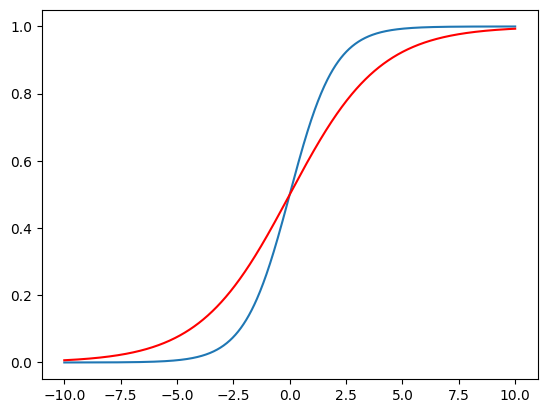

In [162]:

import matplotlib.pyplot as plt

xs = np.linspace(-10, 10, 1000)
ys = 1 / (1 +  np.exp(-xs))
y2s = 1 / (1 +  np.exp(-xs*0.5))
plt.plot(xs, ys)
plt.plot(xs, y2s, c='r')



In [180]:


### todo: bias walk toward zero when rating is extreme
## potential bias term
# ys = xs*0.01+0.5
# plt.plot(xs, ys)

class Player():
    
    def __init__(self, true_rating, performance_std, step_size=0.1):
        self.true_rating=true_rating
        self.performance_std = performance_std
        self.step_size=step_size
        return
    
    def random_step(self):
        self.true_rating = (np.random.random()-0.5)*2*self.step_size
        return self.true_rating
    
    def performance(self):
        observable_score = np.random.normal(self.true_rating, self.performance_std)
        return observable_score
    


def create_league_1v1_random_walks(num_players=24, perf_std=2.5, num_rounds=250, league_size=num_players//3, cross_league_pct=1/6, num_games_per_round=24/3):
    
    player_dict = {}

    num_leagues = num_players//league_size
    league_means = np.linspace(-1, 1, num_leagues)
    league_std = 1
    
    league_dict = {}
    for j in range(num_leagues):
        league_dict[str(j)] = []
        for i in range(league_size):
            player_id = str(i)+'_'+str(j)
            player_dict[player_id] = Player(true_rating=np.random.normal(league_means[j], league_std), performance_std=perf_std)
            league_dict[str(j)].append(player_id)
            
    print(league_dict)
    results = []
#     for i in range(num_rounds):
        ## cross league round or no
        
            
    
    
    return

create_league_1v1_random_walks()


{'0': ['0_0', '1_0', '2_0', '3_0', '4_0', '5_0', '6_0', '7_0', '8_0', '9_0', '10_0', '11_0'], '1': ['0_1', '1_1', '2_1', '3_1', '4_1', '5_1', '6_1', '7_1', '8_1', '9_1', '10_1', '11_1']}


In [174]:
Player()


In [172]:

num_players = 36
league_size=num_players//3

print(league_mean)
print(np.mean([np.random.normal(1,1)>np.random.normal(0,1) for i in range(10000)]))
print(np.mean([np.random.normal(1,1)>np.random.normal(-1,1) for i in range(10000)]))


[-1.  0.  1.]
0.7573
0.9178


0.7558